# QPE Wave Visualisation Demo

We would like to visualise the performance of different quantum backend without staring at boring graphs or tables. In this chapter we create a cool visualisation using the quantum phase estimation algorithm (an algorithm we are likely to use in a real application) and see the effect different backends and error corrections have on this visualisation.

To create a frame, we fill a grid with different values according to some rule (in this case, their distance from the centre). We then use these values to parametrise $U$, the gate we use QPE to find the phase of. We then perform QPE on 5 qubits, (4 counting bits and one ancilla qubit to apply $U$ to) and put the results back into the grid.

To animate, we affect the rule that creates the grid by the frame number (in this case, we simply offset the values by the frame number).

First, import everything we’ll need:


In [2]:
# Import everything
from qiskit import QuantumCircuit, Aer, IBMQ, execute, transpile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from time import sleep, time
from qiskit.providers.aer.noise import NoiseModel
from operator import attrgetter
# For creating and displaying the GIFs:
from PIL import Image
from IPython.display import Image as IPYImage
import ipywidgets

Next we set some parameters:

In [3]:
npix = 32          # Number of pixels along one axis
nframes = 32       # Number of frames in animation
n = 5              # Number of qubits to use
freq = 1           # Frequency of 'waves'
gif_name = "qpe_animation" # Name of animated gif file

We need to define the QPE circuit. The function `phase_estimate` returns a `QuantumCircuit` object that performs QPE using `n` qubits, on a gate with a phase of `theta`. You can read more about the QPE algorithm in the [Qiskit Textbook](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html).

In [3]:
# Define the QPE function:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(int(n/2)):
        circ.swap(qubit, n-qubit-1)
    for j in range(n,0,-1):
        k = n - j
        for m in range(k):
            circ.cu1(-math.pi/float(2**(k-m)), n-m-1, n-k-1)
        circ.h(n-k-1)

def phase_estimate(n, theta):
    """Does QPE on CU-gate with angle theta, using n qubits"""
    qpe = QuantumCircuit(n, n-1)
    qpe.x(n-1)
    for qubit in range(n-1):
        qpe.h(qubit)
    repetitions = (n-2)**2
    for counting_qubit in range(n-1):
        for i in range(repetitions):
            qpe.cu1(theta, counting_qubit, n-1); # This is C-U
        repetitions //= 2
    qft_dagger(qpe, n-1)
    for qubit in range(n-1):
        qpe.measure(qubit, (n-2)-qubit)
    return qpe

In [4]:
# Setup backend
noise_model = None
device = None
backend = Aer.get_backend('qasm_simulator')

Now we can simulate the circuits and create our visualisation. For each pixel in the image, we perform a QPE circuit that takes a different `theta` value (in this case proportional to the distance from the center of the image) and use the results of the simulation to tell us what colour that pixel should be:

In [5]:
def render_frame(n, freq, frame, name, qpe_function, optimization_level=1, verbose=False):
    # Set placeholder lists
    qc_list = []
    pixels = []
    if verbose: print("Building Circuits [",end="")
    for x in range(npix):
        pixels.append([])
        for y in range(npix):
            # Set Theta for the CU-gate
            theta = (math.pi*freq/8)*(math.sqrt((x-npix/2)**2 + (y-npix/2)**2)+(frame))
            # Next create the QuantumCircuit and add it to qc_list
            qc = qpe_function(n,theta)
            qc_list.append(qc)
            # remember which circuit corresponds to which pixel
            pixels[x].append(qc.name)
        if verbose: print("-", end="")
    if verbose: print("]", end="")
    
    # Transpile and simulate our circuits
    if verbose: print("Executing... ", end="")
    transpiled_qc_list_1 = transpile(qc_list, device, optimization_level=optimization_level)
    results = execute(transpiled_qc_list_1, backend=backend, shots=1, noise_model=noise_model).result()
    
    # Convert the results into an image
    if verbose: print("Saving Results [",end="")
    for x in range(npix):
        for y in range(npix):
            value = list(results.get_counts(pixels[x][y]))[0]
            value = int(value,2)
            pixels[x][y] = value
        if verbose: print("-", end="")
    plt.imsave("frames/%s%i.png" % (name, frame), pixels)
    if verbose: print("]")

Let's try this with a single image to check the function works correctly. We need to rescale the image up so it's not tiny.

Building Circuits [--------------------------------]Executing... Saving Results [--------------------------------]


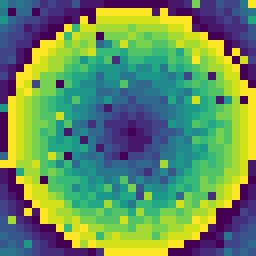

In [6]:
render_frame(n, freq, 0, 'test', phase_estimate, optimization_level=0, verbose=True)
# Rescale image so it's not tiny:
im = Image.open('frames/test0.png')
im = im.resize((256,256), Image.NEAREST)
# Re-save the rescaled image:
im.save('frames/test0.png')
# Display the image in the notebook:
IPYImage('frames/test0.png')

Cool! Now it's time to do our first animation. Let's try the QPE circuit on a simulated perfect quantum computer:

In [7]:
# Render Multiple Frames
for frame in range(nframes):
    t0 = time()
    render_frame(n, freq, frame, 'frame', phase_estimate)
    t1 = time()
    print("Finished Frame %i in %.2f seconds" % (frame, (t1-t0)))

Finished Frame 0 in 6.23 seconds
Finished Frame 1 in 6.60 seconds
Finished Frame 2 in 7.05 seconds
Finished Frame 3 in 6.69 seconds
Finished Frame 4 in 6.45 seconds
Finished Frame 5 in 6.58 seconds
Finished Frame 6 in 6.60 seconds
Finished Frame 7 in 6.56 seconds
Finished Frame 8 in 6.71 seconds
Finished Frame 9 in 6.45 seconds
Finished Frame 10 in 6.55 seconds
Finished Frame 11 in 6.42 seconds
Finished Frame 12 in 7.25 seconds
Finished Frame 13 in 6.60 seconds
Finished Frame 14 in 6.56 seconds
Finished Frame 15 in 6.65 seconds
Finished Frame 16 in 6.48 seconds
Finished Frame 17 in 6.57 seconds
Finished Frame 18 in 6.63 seconds
Finished Frame 19 in 6.40 seconds
Finished Frame 20 in 6.55 seconds
Finished Frame 21 in 6.70 seconds
Finished Frame 22 in 6.46 seconds
Finished Frame 23 in 6.45 seconds
Finished Frame 24 in 6.62 seconds
Finished Frame 25 in 6.58 seconds
Finished Frame 26 in 6.58 seconds
Finished Frame 27 in 6.43 seconds
Finished Frame 28 in 6.64 seconds
Finished Frame 29 in 6.8

Now we've rendered all our frames, we can combine this into an animated GIF and display it in the notebook:

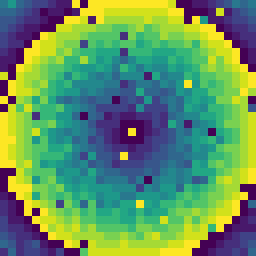

In [8]:
# Convert to animated gif
def make_gif(gif_name, frame_name, nframes):
    im_list = []
    for frame in range(nframes):
        i = Image.open('frames/frame%i.png' % frame)
        # Rescale image so it's not tiny
        i = i.resize((256,256), Image.NEAREST)
        im_list.append(i)

    im_list.reverse() # to make waves move outwards
    im_list[0].save('animations/%s.gif' % gif_name, 
                    save_all=True, 
                    append_images=im_list[1:], 
                    optimize=False, 
                    duration=100, 
                    loop=0)

make_gif(gif_name+"_perfect", 'frame', nframes)
# Display image in notebook:
IPYImage('animations/%s_perfect.gif' % gif_name)

Now we have our perfect reference animation, we now want to see what this might look like on a real quantum computer. We will use the QASM simulator to simulate IBM's Vigo device. Let's set this up now:

In [9]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(device)

In [10]:
for frame in range(nframes):
    t0 = time()
    render_frame(n, freq, frame, 'frame', phase_estimate, optimization_level=0)
    t1 = time()
    print("Frame %i (%.2fs) / " % (frame, (t1-t0)), end="")
make_gif(gif_name+"_opt0", 'frame', nframes)

Frame 0 (24.92s) / Frame 1 (25.99s) / Frame 2 (23.99s) / Frame 3 (24.34s) / Frame 4 (24.75s) / Frame 5 (23.59s) / Frame 6 (23.98s) / Frame 7 (24.05s) / Frame 8 (23.93s) / Frame 9 (24.22s) / Frame 10 (24.88s) / Frame 11 (24.04s) / Frame 12 (25.35s) / Frame 13 (25.08s) / Frame 14 (23.71s) / Frame 15 (24.92s) / Frame 16 (25.04s) / Frame 17 (25.60s) / Frame 18 (24.79s) / Frame 19 (23.63s) / Frame 20 (24.22s) / Frame 21 (24.72s) / Frame 22 (23.71s) / Frame 23 (23.86s) / Frame 24 (24.92s) / Frame 25 (23.88s) / Frame 26 (25.17s) / Frame 27 (24.66s) / Frame 28 (25.08s) / Frame 29 (23.95s) / Frame 30 (23.60s) / Frame 31 (22.65s) / 

The purpose of this visualisation is to illustrate the effects of the different optimisations we can make. Let's now try the same animation with the optimisation level set to 3 and see what happens to our animation:

Let's see these side by side, we can really see the noise from errors in the quantum computation in the Vigo simulation.

In [6]:
%%HTML
<table>
<tr style="text-align: center">
    <td style="width: 50%;"> Perfect Simulation </td>
    <td style="width: 50%;"> Vigo Simulation </td>
</tr>
<tr>
    <td><img src="animations/qpe_animation_perfect.gif"></td>
    <td><img src="animations/qpe_animation_opt0.gif"></td>
</tr>
</table>

Perfect Simulation,Vigo Simulation
,


The easiest thing we can do to improve these results is setting the `optimization_level` parameter to it's maximum value of 3. Let's see what effect that has:

In [12]:
for frame in range(nframes):
    t0 = time()
    render_frame(n, freq, frame, 'frame', phase_estimate, optimization_level=3)
    t1 = time()
    print("Frame %i (%.2fs) / " % (frame, (t1-t0)), end="")
make_gif(gif_name+"_opt3", 'frame', nframes)

Frame 0 (73.25s) / Frame 1 (71.28s) / Frame 2 (76.09s) / Frame 3 (74.13s) / Frame 4 (72.43s) / Frame 5 (72.67s) / Frame 6 (73.71s) / Frame 7 (71.99s) / Frame 8 (70.22s) / Frame 9 (70.63s) / Frame 10 (71.82s) / Frame 11 (69.48s) / Frame 12 (70.53s) / Frame 13 (69.79s) / Frame 14 (70.53s) / Frame 15 (71.27s) / Frame 16 (73.30s) / Frame 17 (72.04s) / Frame 18 (72.30s) / Frame 19 (71.09s) / Frame 20 (72.20s) / Frame 21 (72.95s) / Frame 22 (72.31s) / Frame 23 (72.60s) / Frame 24 (71.72s) / Frame 25 (71.37s) / Frame 26 (71.44s) / Frame 27 (71.16s) / Frame 28 (71.54s) / Frame 29 (71.89s) / Frame 30 (69.80s) / Frame 31 (71.89s) / 

In [7]:
%%HTML
<table>
<tr style="text-align: center">
    <td style="width: 30%;"> Perfect Simulation </td>
    <td style="width: 30%;"> Vigo (optimisation 0) </td>
    <td style="width: 30%;"> Vigo (optimisation 3) </td>
</tr>
<tr>
    <td><img src="animations/qpe_animation_perfect.gif"></td>
    <td><img src="animations/qpe_animation_opt0.gif"></td>
    <td><img src="animations/qpe_animation_opt3.gif"></td>
</tr>
</table>

Perfect Simulation,Vigo (optimisation 0),Vigo (optimisation 3)
,,


The transpiler doesn't always get the same result when compiling the same circuit for the same backend. Sometimes it does better than others. We can try and improve transpiler results by transpiling each circuit three times and picking the result with the lowest circuit depth. Here's a the modified `render_frame` function that does three transpiler passes instead of 1:

In [14]:
def render_frame_mtp(n, freq, frame, name, qpe_function, optimization_level=1, verbose=False):
    # Set placeholder lists
    qc_list = []
    pixels = []
    if verbose: print("Building Circuits [",end="")
    for x in range(npix):
        pixels.append([])
        for y in range(npix):
            # Set Theta for the CU-gate
            theta = (math.pi*freq/8)*(math.sqrt((x-npix/2)**2 + (y-npix/2)**2)+(frame))
            # Next create the QuantumCircuit and add it to qc_list
            qc = qpe_function(n,theta)
            qc_list.append(qc)
            # remember which circuit corresponds to which pixel
            pixels[x].append(qc.name)
        if verbose: print("-", end="")
    if verbose: print("]", end="")
    
    # Transpile and simulate our circuits
    if verbose: print("Executing... ", end="")
    tqc1 = transpile(qc_list, device, optimization_level=optimization_level)
    tqc2 = transpile(qc_list, device, optimization_level=optimization_level)
    tqc3 = transpile(qc_list, device, optimization_level=optimization_level)
    tqc_best = []
    # select circuits with lowest depths
    for i in range(len(tqc1)):
        tqc_best.append(min([tqc1[i], tqc2[i], tqc3[i]], key=lambda x: x.depth()))
    
    results = execute(tqc_best, backend=backend, shots=1, noise_model=noise_model).result()
    
    # Convert the results into an image
    if verbose: print("Saving Results [",end="")
    for x in range(npix):
        for y in range(npix):
            value = list(results.get_counts(pixels[x][y]))[0]
            value = int(value,2)
            pixels[x][y] = value
        if verbose: print("-", end="")
    plt.imsave("frames/%s%i.png" % (name, frame), pixels)
    if verbose: print("]")

In [15]:
for frame in range(nframes):
    t0 = time()
    render_frame_mtp(n, freq, frame, 'frame', phase_estimate, optimization_level=3)
    t1 = time()
    print("Frame %i (%.2fs) / " % (frame, (t1-t0)), end="")
make_gif(gif_name+"_opt3_mtp", 'frame', nframes)

Frame 0 (201.93s) / Frame 1 (196.99s) / Frame 2 (197.95s) / Frame 3 (195.17s) / Frame 4 (199.62s) / Frame 5 (193.02s) / Frame 6 (195.34s) / Frame 7 (190.87s) / Frame 8 (191.87s) / Frame 9 (192.57s) / Frame 10 (192.91s) / Frame 11 (191.35s) / Frame 12 (190.56s) / Frame 13 (188.85s) / Frame 14 (203.93s) / Frame 15 (206.17s) / Frame 16 (191.84s) / Frame 17 (194.02s) / Frame 18 (192.27s) / Frame 19 (191.89s) / Frame 20 (192.70s) / Frame 21 (189.90s) / Frame 22 (189.61s) / Frame 23 (189.46s) / Frame 24 (188.40s) / Frame 25 (189.04s) / Frame 26 (188.38s) / Frame 27 (187.10s) / Frame 28 (188.64s) / Frame 29 (188.41s) / Frame 30 (189.48s) / Frame 31 (187.48s) / 

This made my laptop angry, but it does seem to clear up the pattern even more:

In [8]:
%%HTML
<table>
<tr style="text-align: center">
    <td style="width: 25%;"> Perfect Simulation </td>
    <td style="width: 25%;"> Vigo (optimisation 0) </td>
    <td style="width: 25%;"> Vigo (optimisation 3) </td>
    <td style="width: 25%;"> Vigo (optimisation 3 / Multiple Transpiler Passes) </td>
</tr>
<tr>
    <td><img src="animations/qpe_animation_perfect.gif"></td>
    <td><img src="animations/qpe_animation_opt0.gif"></td>
    <td><img src="animations/qpe_animation_opt3.gif"></td>
    <td><img src="animations/qpe_animation_opt3_mtp.gif"></td>
</tr>
</table>

Perfect Simulation,Vigo (optimisation 0),Vigo (optimisation 3),Vigo (optimisation 3 / Multiple Transpiler Passes)
,,,


Finally, let's make some changes to the circuit itself. I'm going use the approximate quantum Fourier transform, and remove the smallest `cu1` gates, since these have the biggest effect on circuit depth and the lowest effect on the results. In this example, the AQFT doesn't seem to improve the visualisation, but it does seem to soften it.

In [17]:
# Define the QPE function:
def aqft_dagger(circ, n, threshold=0):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(int(n/2)):
        circ.swap(qubit, n-qubit-1)
    for j in range(n,0,-1):
        k = n - j
        for m in range(k):
            if math.pi/float(2**(j-m)) > threshold:
                circ.cu1(-math.pi/float(2**(k-m)), n-m-1, n-k-1)
        circ.h(n-k-1)

def approx_phase_estimate(n, theta):
    """Does QPE on CU-gate with angle theta, using n qubits"""
    qpe = QuantumCircuit(n, n-1)
    qpe.x(n-1)
    for qubit in range(n-1):
        qpe.h(qubit)
    repetitions = (n-2)**2
    for counting_qubit in range(n-1):
        for i in range(repetitions):
            qpe.cu1(theta, counting_qubit, n-1); # This is C-U
        repetitions //= 2
    aqft_dagger(qpe, n-1, threshold=0.4)
    for qubit in range(n-1):
        qpe.measure(qubit, (n-2)-qubit)
    return qpe

In [18]:
for frame in range(nframes):
    t0 = time()
    render_frame_mtp(n, freq, frame, 'frame', approx_phase_estimate, optimization_level=3)
    t1 = time()
    print("Frame %i (%.2fs) / " % (frame, (t1-t0)), end="")
make_gif(gif_name+"_opt3_mtp_approx", 'frame', nframes)

Frame 0 (189.39s) / Frame 1 (183.96s) / Frame 2 (193.39s) / Frame 3 (196.76s) / Frame 4 (184.10s) / Frame 5 (184.74s) / Frame 6 (184.96s) / Frame 7 (184.51s) / Frame 8 (183.57s) / Frame 9 (186.53s) / Frame 10 (184.65s) / Frame 11 (183.78s) / Frame 12 (184.49s) / Frame 13 (186.05s) / Frame 14 (184.65s) / Frame 15 (188.17s) / Frame 16 (190.56s) / Frame 17 (191.00s) / Frame 18 (190.96s) / Frame 19 (190.73s) / Frame 20 (192.32s) / Frame 21 (194.06s) / Frame 22 (192.16s) / Frame 23 (192.15s) / Frame 24 (197.74s) / Frame 25 (192.76s) / Frame 26 (191.55s) / Frame 27 (191.16s) / Frame 28 (191.39s) / Frame 29 (197.40s) / Frame 30 (194.18s) / Frame 31 (198.03s) / 

In [9]:
%%HTML
<table style="table-layout: fixed;">
<tr style="text-align: center;">
    <td style="width: 20%;"> Perfect Simulation </td>
    <td style="width: 20%;"> Vigo (optimisation 0) </td>
    <td style="width: 20%;"> Vigo (optimisation 3) </td>
    <td style="width: 20%;"> Vigo (optimisation 3 / Multiple Transpiler Passes) </td>
    <td style="width: 20%;"> Vigo (optimisation 3 / Multiple Transpiler Passes / AQFT) </td>
</tr>
<tr>
    <td><img src="animations/qpe_animation_perfect.gif"></td>
    <td><img src="animations/qpe_animation_opt0.gif"></td>
    <td><img src="animations/qpe_animation_opt3.gif"></td>
    <td><img src="animations/qpe_animation_opt3_mtp.gif"></td>
    <td><img src="animations/qpe_animation_opt3_mtp_approx.gif"></td>
</tr>
</table>

Perfect Simulation,Vigo (optimisation 0),Vigo (optimisation 3),Vigo (optimisation 3 / Multiple Transpiler Passes),Vigo (optimisation 3 / Multiple Transpiler Passes / AQFT)
,,,,
